## Ensemble Models – A Classification Project Using XGBoost for the Hotel Industry

### **1. Objetives**

Applying ensemble models techniques to solve classification problems using XGBoost.

### **2. Problem Context**

In the hotel industry, it is essential to estimate whether a customer will follow through with a reservation. In this case, we have a dataset containing information on customer behavior related to hotel reservations and whether those reservations were honored or canceled. This project will implement XGBoost to predict whether a customer will cancel their reservation and classify the reservation status based on observed behavior.

### 3. **Model Implementation**

#### **a. Importing Libraries**

First, all the libraries required for this classification problem will be imported.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import warnings # Ignore warnings
warnings.filterwarnings("ignore")

#### **b. Data reading and analysis**

The data will be read. Additionally, duplicated and null values will be identified.

In [2]:
# Data reading.
df = pd.read_csv("/Users/sergiooyola/Desktop/GitHub_Projects/MachineLearning_HotelCancellations/dataset.csv")

# Let's have a look at the data.
df.head()

,Unnamed: 0,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_date,...,arrival_month_4,arrival_month_5,arrival_month_6,arrival_month_7,arrival_month_8,arrival_month_9,arrival_month_10,arrival_month_11,arrival_month_12,booking_status
0,0,0.50,0.0,0.000000,0.117647,0.333333,0.0,0.0,0.020316,0.433333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.50,0.0,0.142857,0.117647,0.000000,0.0,0.0,0.264108,0.933333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.50,0.0,0.000000,0.058824,0.000000,0.0,0.0,0.711061,0.033333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,0.25,0.0,0.000000,0.117647,0.333333,0.0,0.0,0.072235,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,0.50,0.0,0.142857,0.000000,0.000000,0.0,0.0,0.582393,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [3]:
# Duplicate values validation.
df.duplicated().sum()

0

In [4]:
# Null values validation.
df.isna().sum()

Unnamed: 0                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
arrival_month_1                         0
arrival_month_2                         0
arrival_month_3                         0
arrival_month_4                         0
arrival_month_5                         0
arrival_month_6                         0
arrival_month_7                         0
arrival_month_8                   

In [5]:
# The column booking_status is the target variable, it will be separated from the rest of the dataset.
dfx = df.drop(['booking_status','Unnamed: 0'],axis=1)
dfy = df['booking_status']

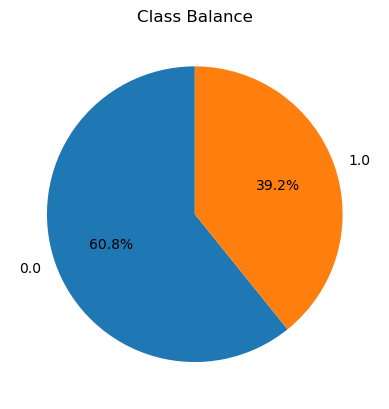

In [6]:
# Plot the class distribution using a pie chart.
plt.pie(dfy.value_counts(), labels=dfy.unique(), autopct='%1.1f%%', startangle=90)
plt.title('Class Balance')
plt.show()

#### **c. Data splitting**

The data will be split into three: train: 60% - test: 20% - validation: 20%

In [7]:
# First, let's get our test sample:
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

# A portion of the train data can be used for validation, although it will not be used for this exercise.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1337)

#### **d. Base model**

Creation of a classifier using Random Forest to establish a baseline model for comparing the performance of XGBoost.

Model accuracy:  0.753206650831354


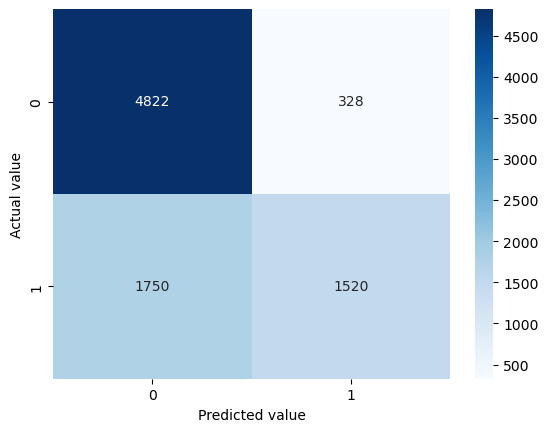

In [8]:
# Model initialization.
clf = RandomForestClassifier(max_depth=3, random_state=42)

# Model training.
clf.fit(X_train, y_train)

# Model prediction.
y_pred = clf.predict(X_test)

# Model accuracy.
accuracy_base = accuracy_score(y_test, y_pred)
print("Model accuracy: ", accuracy_base)

# Confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot.
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.show()

In [9]:
# Classification report.
print("\nClassification Report - Base model:\n")
print(classification_report(y_test, y_pred))


Classification Report - Base model:

              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82      5150
         1.0       0.82      0.46      0.59      3270

    accuracy                           0.75      8420
   macro avg       0.78      0.70      0.71      8420
weighted avg       0.77      0.75      0.73      8420



The base model achieves an overall accuracy of 75%, but the performance differs significantly between the two classes. For Class 0 (non-cancellations), the model performs well, with a recall of 94% and an F1-score of 82%, indicating that most non-cancellations are correctly identified.

However, the model struggles with Class 1 (cancellations), achieving only 46% recall, meaning it misses more than half of the actual cancellations, which is the most important class for this classification problem.

#### **e. XGBoost: Searching for the optimal number of estimators**

The impact of the number of estimators on the model’s performance will be explored. The basic steps include:

1. Initializing the model.
2. Generating a parameter grid to train multiple models.
3. Splitting the data using k-fold cross-validation.
4. Training the models.
5. Generating the plots of the means and standard deviations, calculated from the trained models across the k data splits.

Best model for the error function: -0.408607 using {'n_estimators': 55}
neg_log_loss
-0.451798 (0.005850) with: {'n_estimators': 5}
-0.427809 (0.008699) with: {'n_estimators': 10}
-0.420584 (0.008682) with: {'n_estimators': 15}
-0.416701 (0.008052) with: {'n_estimators': 20}
-0.413814 (0.008476) with: {'n_estimators': 25}
-0.411834 (0.008511) with: {'n_estimators': 30}
-0.410474 (0.008620) with: {'n_estimators': 35}
-0.409818 (0.008711) with: {'n_estimators': 40}
-0.409317 (0.008222) with: {'n_estimators': 45}
-0.408712 (0.009114) with: {'n_estimators': 50}
-0.408607 (0.009364) with: {'n_estimators': 55}
-0.408773 (0.009390) with: {'n_estimators': 60}
-0.408940 (0.009862) with: {'n_estimators': 65}
-0.408942 (0.010407) with: {'n_estimators': 70}
-0.409449 (0.011197) with: {'n_estimators': 75}


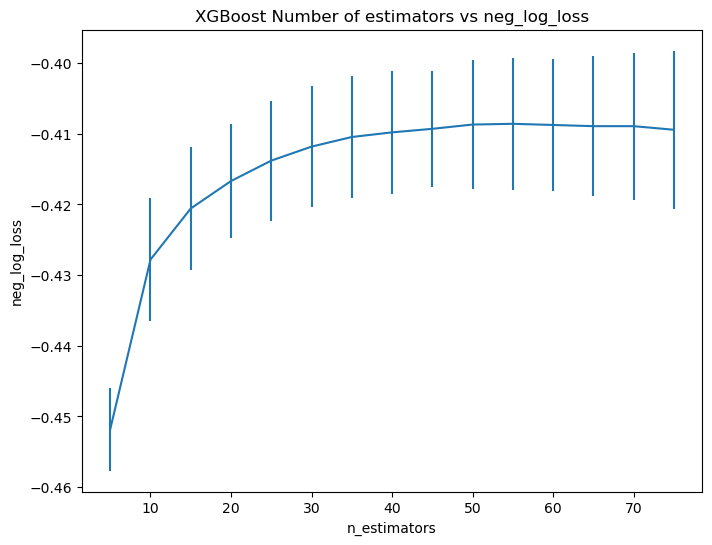

accuracy
0.806057 (0.005164) with: {'n_estimators': 5}
0.809145 (0.005203) with: {'n_estimators': 10}
0.811797 (0.005272) with: {'n_estimators': 15}
0.814608 (0.004843) with: {'n_estimators': 20}
0.814568 (0.005035) with: {'n_estimators': 25}
0.815321 (0.005082) with: {'n_estimators': 30}
0.816112 (0.004108) with: {'n_estimators': 35}
0.816667 (0.004050) with: {'n_estimators': 40}
0.817181 (0.003856) with: {'n_estimators': 45}
0.815439 (0.003968) with: {'n_estimators': 50}
0.815360 (0.004196) with: {'n_estimators': 55}
0.815360 (0.004707) with: {'n_estimators': 60}
0.815954 (0.004413) with: {'n_estimators': 65}
0.816310 (0.004734) with: {'n_estimators': 70}
0.815360 (0.005722) with: {'n_estimators': 75}


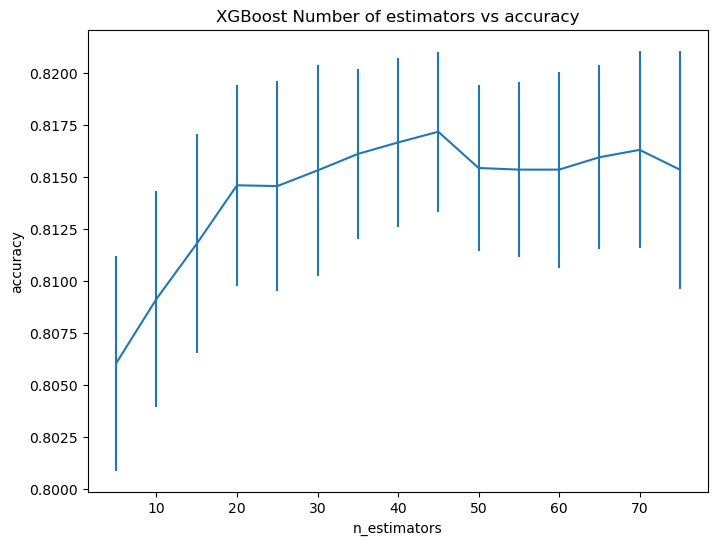

In [10]:
# Initializing the model.
model = XGBClassifier()

# Searching for the best model based on the number of estimators. Generation of parameters to train multiple models.
n_estimators = range(5, 80, 5)
param_grid = dict(n_estimators=n_estimators)

# Data splitting using K-cross validation.
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Score definition.
scoring = ['neg_log_loss','accuracy']

# The GridSearch function will be used to train the model based on the parameters.
# ... In this case, the only parameter being tuned is n_estimators based on neg_log_loss (loss function).
grid_search = GridSearchCV(model, param_grid, scoring=scoring, refit='neg_log_loss', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# Summarizing the results of each model and extracting the best number of estimators.
print("Best model for the error function: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Code that plots the mean and standard deviation of the error function and accuracy
# ... calculated from the trained models, using the k data splits.
for s in scoring:
    print(s)
    means = grid_result.cv_results_[f'mean_test_{s}']
    stds = grid_result.cv_results_[f'std_test_{s}']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        plt.close()
        print("%f (%f) with: %r" % (mean, stdev, param))
        # Plot error and accuracy as a function of the number of estimators.
        plt.figure(figsize=(8,6))
        plt.errorbar(n_estimators, means, yerr=stds)
        plt.title(f"XGBoost Number of estimators vs {s}")
        plt.xlabel('n_estimators')
        plt.ylabel(f'{s}')
    plt.show()


It can be observed that the best number of estimator is n_estimators=55 based on the error funtion (neg_log_loss). However, the best number of estimators is n_estimators=45 based on the accuracy metric. This may be due to the standard deviations in cross-validation, but further analysis is required through the confusion matrix.

#### **f. Training and results of the best model**

The models with n_estimators=55 and n_estimators=45 will be trained to evaluate their performance. The confusion matrix and classification report will be generated for each model to provide a comprehensive analysis of their predictive capabilities.

Model accuracy:  0.8204275534441805


Text(50.722222222222214, 0.5, 'Actual')

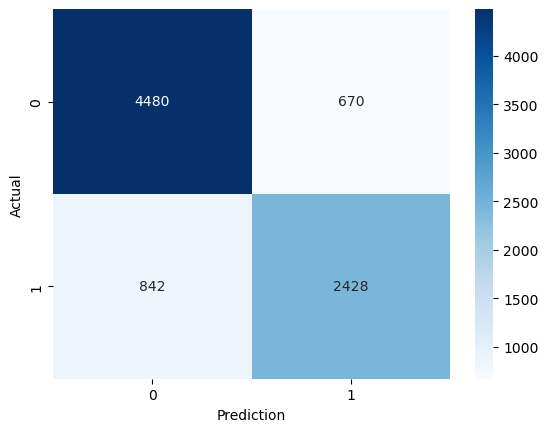

In [11]:
# Model initialization with 55 estimators.
model = XGBClassifier(n_estimators = 55)

# Model training.
modelfit = model.fit(X_train, y_train)

# Model prediction.
prediction = modelfit.predict(X_test)

# Accuracy score.
print("Model accuracy: ", accuracy_score(y_test, prediction))

# Confusion matrix.
cm = confusion_matrix(y_test, prediction)

# Confusion matrix plot.
sns.heatmap(cm ,annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [12]:
# Classification report.
print("\nClassification Report - n_estimators=55:\n")
print(classification_report(y_test, prediction))


Classification Report - n_estimators=55:

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      5150
         1.0       0.78      0.74      0.76      3270

    accuracy                           0.82      8420
   macro avg       0.81      0.81      0.81      8420
weighted avg       0.82      0.82      0.82      8420



Model accuracy:  0.8199524940617577


Text(50.722222222222214, 0.5, 'Verdad')

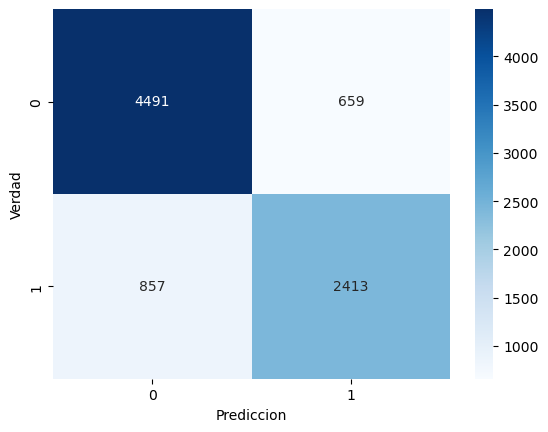

In [13]:
# Model initialization with 45 number of estimators.
model2 = XGBClassifier(n_estimators = 45)

# Model training.
modelfit2 = model2.fit(X_train, y_train)

# Model prediction.
prediction2 = modelfit2.predict(X_test)

# Accuracy score.
print("Model accuracy: ", accuracy_score(y_test, prediction2))

# Confusion matrix.
cm2 = confusion_matrix(y_test, prediction2)

# Confusion matrix plot.
sns.heatmap(cm2, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Prediccion')
plt.ylabel('Verdad')

In [14]:
# Classification report.
print("\nClassification Report - n_estimators=45:\n")
print(classification_report(y_test, prediction2))


Classification Report - n_estimators=45:

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      5150
         1.0       0.79      0.74      0.76      3270

    accuracy                           0.82      8420
   macro avg       0.81      0.80      0.81      8420
weighted avg       0.82      0.82      0.82      8420



#### **g. Feature analysis**

The importance of each feature (variable) will be analysed through a bar chart.

Text(0.5, 0, 'Xgboost Feature Importance')

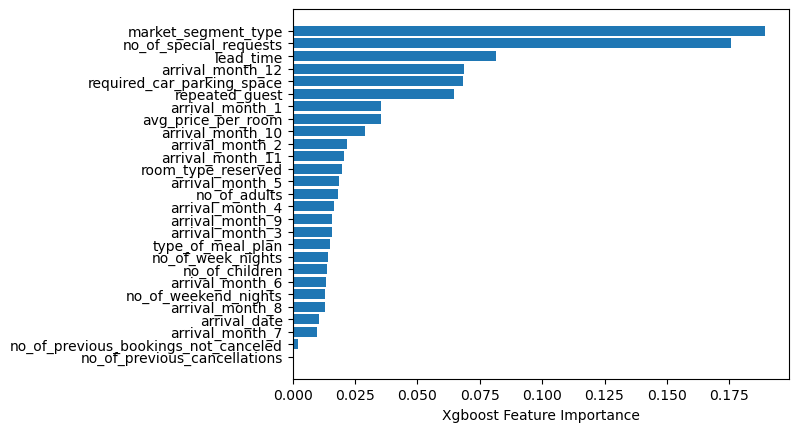

In [15]:
sorted_idx = modelfit.feature_importances_.argsort()
plt.barh(dfx.columns[sorted_idx], modelfit.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

#### **h. Conclusions**

This analysis suggests that both models, with 45 and 55 estimators, demonstrate comparable performance, achieving an accuracy of 81.99% and 82.04% respectively. While the difference in overall accuracy is marginal, the model with 45 estimators offers slightly better precision for the cancellation class (0.79 vs. 0.78), meaning it produces fewer false positives.

Both models achieve a similar balance between recall and precision, correctly identifying around 74% of actual cancellations. As a result, either model could effectively support predictive strategies aimed at mitigating booking cancellations and optimizing resource management.

Additionally, the feature importance analysis highlights key drivers of cancellations, such as **market segment, number of special requests, and lead time.** These variables can provide valuable insights for developing customer engagement strategies aimed at reducing cancellations and improving operational efficiency.

#### **i. Final comments and further steps**

The number of estimators and the depth of the trees are two critical hyperparameters in XGBoost models. Although they can significantly impact the model's performance, they represent part of the essential components of ensemble models.

##### **Influence of the number of estimators**
- **Initial performance improvement:** Increasing the number of estimators (`n_estimators`) adds more trees to the ensemble, typically improving the model’s ability to learn complex patterns from the data. This generally results in better accuracy and a reduction in the error function (e.g., log loss) up to a certain point.

- **Optimal performance point:** However, there is a point where adding more estimators yields diminishing returns and may even degrade performance on new data due to overfitting. The best performance was achieved with `n_estimators = 45`, suggesting this is the optimal balance between bias and variance for the dataset.

- **Computational cost:** Increasing the number of estimators also raises computational cost and training time. Therefore, it’s essential to find a balance that maximizes accuracy without incurring unnecessary computational expenses.

##### **Influence of tree depth**
- **Capturing complex relationships:** Tree depth (`max_depth`), which was not explored in this project, determines how well each tree can capture interactions between features. Greater depth allows the model to learn more intricate relationships, potentially improving accuracy.

- **Risk of overfitting:** However, very deep trees can lead the model to overfit the training data, capturing noise and specific details that do not generalize well to new data. This increases the risk of overfitting, reducing accuracy on the test set and increasing the error function.

- **Need for balance:** It is crucial to find an optimal depth that enables the model to learn meaningful patterns without overfitting. This is often achieved through cross-validation and hyperparameter tuning.

##### **General conclusion**
- **Interaction between Hyperparameters:** Both the number of estimators and the depth of the trees interact in determining the model’s performance. An appropriate number of estimators with optimally deep trees can result in a robust and accurate model.

- **Importance of hyperparameter search:** To fully understand the influence of both hyperparameters, it is recommended to perform a grid search or random search that includes variations in both `n_estimators` and `max_depth`. This allows exploration of how different combinations affect accuracy and the error function.

- **Regularization strategies:** XGBoost offers regularization techniques that can help control overfitting, even when using deep trees or a large number of estimators. Adjusting parameters like the learning_rate is also essential for optimizing performance.

##### **Recommendations**
- **Expand hyperparameter search:** Include `max_depth` and `learning_rate` in the hyperparameter search using grid search. For example:

  ```python
  param_grid = {
      'n_estimators': range(1, 21, 2),
      'max_depth': [3, 5, 7, 9],
      'learning_rate': [0.01, 0.05, 0.1]
  }

- **Handle Class Imbalance:** Although this aspect was not covered in the current notebook, a pie chart presented above revealed the presence of some class imbalance. Implementing techniques to balance the dataset could potentially improve the model's performance and results.